In the following code cell, we mount to Google drive so that its features can be used to A) To read our 'object_tracking.mp4' file and
           B) save frames, so that they can be used to plot later.

In [ ]:
# mounting to google drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In this code snippet, here we give the path to folder we will be accessing

In [ ]:
# accessing the folder
path_to_folder = "ENPM673/Project1"
%cd /content/drive/My\ Drive/{path_to_folder}

/content/drive/My Drive/ENPM673/Project1


Here, we import all the necessary libraries 1) Opencv -for reading,writing images and videos. 2) Numpy- to access the image array and process the image by array indexing. 3) Matplotlib- to plot the least fitted curve, the ball trajectory(centroids) and an image frame

In [ ]:
# importing necessary libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

Here, we first get the video 'object_tracking.mp4'. The we get its FPS value(to be used later in code, so that the video runs at same rate in OpenCV), width and height(useful when plotting the image). We also create empty lists 'centroid_x' and 'centroid_y' to the x and y values of the centroids we calculated.

In [ ]:
# getting the video, its fps,width and height values
video = cv.VideoCapture('object_tracking.mp4')
fps = video.get(cv.CAP_PROP_FPS)
frame_width = video.get(cv.CAP_PROP_FRAME_WIDTH)
frame_height = video.get(cv.CAP_PROP_FRAME_HEIGHT)
centroid_x = []
centroid_y = []
count = 0

***ANSWER TO QUSTION 2 AND 3:*** **Here is an explanation of the following function 'def track_object(frame, threshold = 12)** ---> The function 2 values, an individual frame from the video and a threshold value for thresholding(default is 12). First the frame is converted to grayscale(all elements in the image array are given value 0). Then it is converted to a binary image. Here, all the elements in the image array are inspected. The elements where, the value is below threshold(12) are given a new value of 0 and the rest are given a value of 255 (black and white). This helps in differentiating the object from the background. Then, the if statement checks the entire image array; if all the elements in the array have value 255 (white image, with no object in it), it does nothing. However, if it finds some 0 values, then it finds the indices of all these 0 valued elements(basically, the object). The object array is saved as frame_object, which is a tuple. We then access the tuple by index, where in index 0 gives a list of all the indices along x axis(width) and 1 gives a list of all the indices along y(height). Then we find the mean of all these values, to get the center value. We then append the center values for the object in the empty lists created above for each frame in the video. Hence, we are able to track the centroid of the object in the video. Following is the binary form of a frame in the video 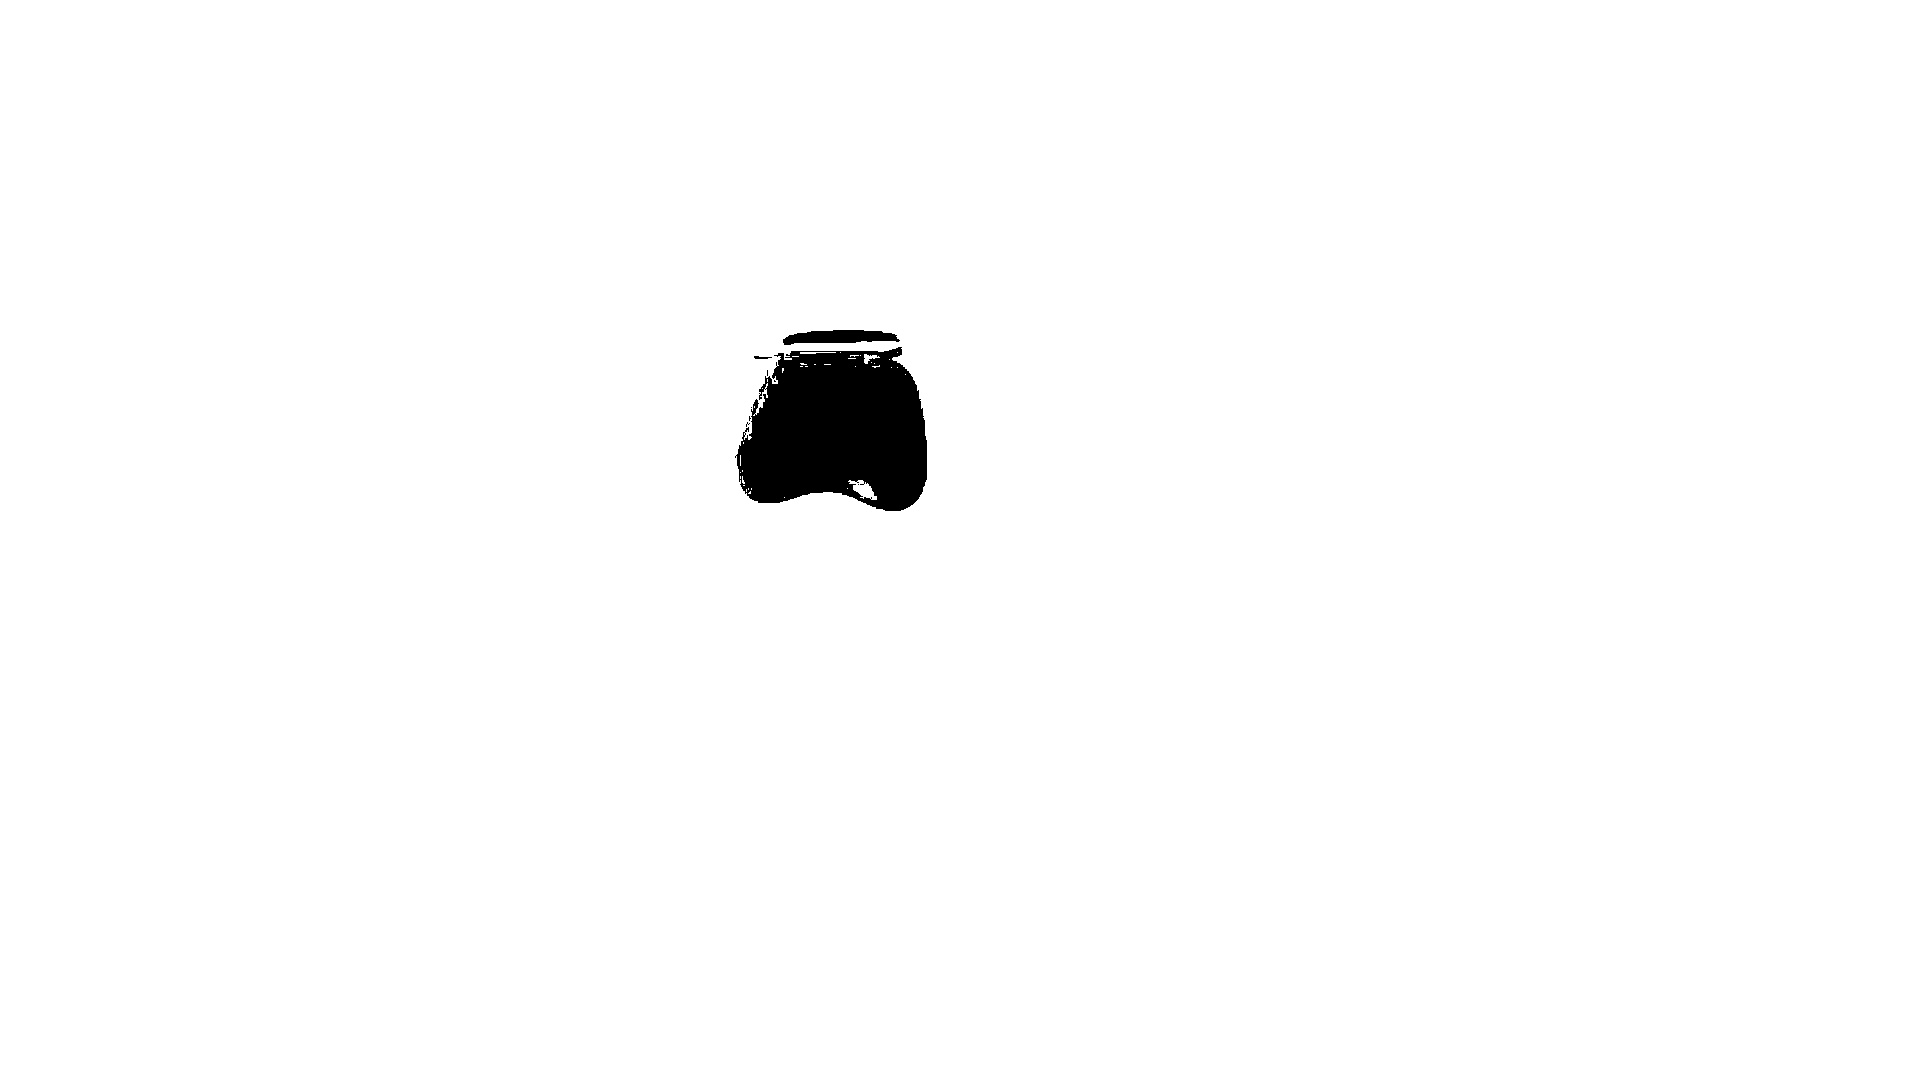

In [ ]:
# A function to track the object
def track_object(frame, threshold= 12):
  # convert to grayscale and the binary
    grayscale = frame[:, :, 0]
    binary_image = np.where(grayscale < threshold, 0, 255)
  # filter the frames with no object
    if np.all(binary_image == 255):
        return None
    else:
  # Find the centroid of the object
        frame_object = np.where(binary_image == binary_image.min())
        x = frame_object[1]
        y = frame_object[0]
        center_x = np.mean(x)
        center_y = np.mean(y)
  # Save the centroid values
        centroid_x.append(center_x)
        centroid_y.append(center_y)

Th function below 'def track_object_single_frame(frame, threshold= 12):' is the same as the function above, just for a single frame


In [ ]:
def track_object_single_frame(frame, threshold= 12):
    grayscale = frame[:, :, 0]
    binary_image = np.where(grayscale < threshold, 0, 255)
    if np.all(binary_image == 255):
        return None
    else:
        frame_object = np.where(binary_image == binary_image.min())
        x = frame_object[1]
        y = frame_object[0]
        center_x = np.mean(x)
        center_y = np.mean(y)
      # return the centroid values
        return center_x,center_y

***ANSWER TO QUESTION 4 AND 5:*** **Here is an explanation of the function 'def least_squares_fitting(x,y):'** ---> Once we get the list of all the cetroid values (x and y) for all the frames in the video (except where the object is not present), we perform least squares fitting on the data points. The function below, takes the list of centroid values as arguments. It then converts them to a numpy array, Then for the x values, an A matrix is created, where the first column is square of all x values, the second column is of the x values and the third column is of all ones. Then the transpose of this matrix is taken. The A matrix and its transpose are multiplied. The inverse of this multiplication is done. Then the inverse is multiplied by the transpose of A. Finally the result matrix is multipled by y. We get a vector 'v' of all the coefficients required for the quadratic equation ax^2 + bx + c. we return these coefficients and the list of fitted y values (to be plotted later).

In [ ]:
# function for least squares fitting
def least_squares_fitting(x,y):
# convert list to array
    x_ = np.array(x)
    x_square = x_**2
    row_one = np.ones_like(x_)
# created a matrix
    A = np.column_stack((x_square, x_, row_one))
# perform some operations on the matrix and matrix multiplication
    A_transpose = np.transpose(A)
    A_T_A = np.dot(A_transpose, A)
    A_T_A_inv = np.linalg.inv(A_T_A)
    A_MPI = np.dot(A_T_A_inv, A_transpose)
    v = np.dot(A_MPI,np.array(y))
    fitted_y = v[0]*x_square + v[1]*x_ + v[2]
    return v[0],v[1],v[2],fitted_y


***ANSWER TO QUESTION 1,2 AND 3:*** In the code snippet below, we just read the video frame by frame ('extract the frames') and pass the frames through the **track_object(frames)** funtion. We also save the frames. We then  release the video.

In [ ]:
# Read the video frame by frame or 'extract' individual frames
while True:
    ret, frames = video.read()
    if ret:
        # cv.imwrite("saved_frames/Frame_%d.jpg"%count, frames)
        track_object(frames)
        count += 1

    else:
        break

    if cv.waitKey(int(1000/fps)) and 0xFF == ord('d'):
        break

video.release()
cv.destroyAllWindows()


***ANSWER TO QUESTION 4 AND 5:*** Here, we get the coefficient values and the list of all the 'fitted' y values. The coeffcients are used to find the y value for a particular x value (1000)

In [ ]:
# call the least squares function to get the coefficients and the y values
a,b,c,fitted_y = least_squares_fitting(centroid_x, centroid_y)
# use the coefficients to find the particular y value for x = 1000 and print it
y_ = a*(1000**2) + b*1000 + c
print(y_)

402.8689882680253


Here, we just read a frame with the object in it. Then we get the x and y values for the centroid of the object in frame

In [ ]:
# Read the image and pass it to the function to get x and y values
image = cv.imread("saved_frames/Frame_436.jpg")
x,y = track_object_single_frame(image)

***ANSWER TO QUESTION 6:*** Here, we just plot the centroids, the fitted curve and the image, with its centroid.** NOTE:** OpenCV takes the top left corner as origin i.e. (0,0) and matplotlib takes the origin as bottom left. Hence I had to flip the original plot to show the actual path of the object. This is done by plt.gca.invert_yaxis().

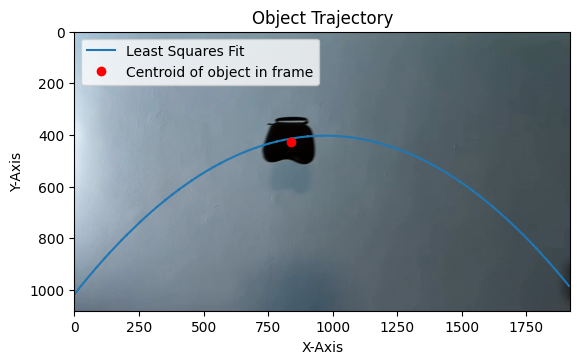

In [ ]:
# Plot the centroids, the curve and and the frame with its cente
# plt.plot(centroid_x, centroid_y,'o',label = "Original Trajectory")
plt.plot(np.array(centroid_x), fitted_y, label = "Least Squares Fit")
plt.plot(x,y,'ro',label = "Centroid of object in frame")
plt.ylim((0, frame_height))
plt.xlim((0, frame_width))
plt.legend(loc="upper left")
plt.xlabel("X-Axis")
plt.ylabel("Y-Axis")
plt.title("Object Trajectory")
plt.gca().invert_yaxis()
plt.imshow(image)
plt.show()